# Plasma frequency varying  $n_0$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import matplotlib
import copy
colorlist = list(matplotlib.colors.TABLEAU_COLORS)

import feltorutilities

from methods.SolutionClass2 import SolutionClass
from methods.make_input import make_plasma_input
from methods.save_load_data2 import save_data, load_data
from methods.misc import dict_ndarr_to_list

In [14]:
params = make_plasma_input()
x_len = (params["grid"]["x"][1]-params["grid"]["x"][0])
params["init"]["type"] = "wave"
params["init"]["amp"] = 0.01
#params["init"]["n_0"] = 1
params["init"]["t_0"] = 1
params["init"]["k"] = 6*np.pi/x_len
params["init"]["x_0"] = 0
params["output"]["tend"] = 4e-3 #1e-4 to 1e-2
params["timestepper"]["type"] = "ARK"
params["timestepper"]["tableau"]  = "ARK-4-2-3"
params["poisson"]["eps"]= 1e-12
params["poisson"]["type"] = "bicgstab"
params["physical"]["type"] = "original"
params["advection"] = {"type" : "staggered", "variant" : "slope-limiter-explicit"}
params["timestepper"]["rtol"] = 1e-5
params["bc"]["density"] = "PER"
params["bc"]["velocity"] = "PER"
params["bc"]["pressure"] = "PER"
params["bc"]["potential"] = "DIR"

params["grid"]["Nx"] = 1000
params["output"]["tend"] = 0.2
params["output"]["maxout"] = 3000

In [15]:
if False:
    for n in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
        params["init"]["n_0"] = n
        sol = SolutionClass(params)
        save_data(sol, filename=f"DATA/Plasma-freq_data varying n0/n={n:.2f}")

In [16]:
sols = []
for n in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
    sols.append(load_data(filename=f"DATA/Plasma-freq_data varying n0/n={n:.2f}"))

Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-5.136503988619014
500
x_peaks = 7286.06627		y_peaks = 27.7929334364
x_peaks = 8416.66276		y_peaks = 14.9964991052
x_peaks = 9421.63741		y_peaks = 8.8675459159
x_peaks = 10332.39570		y_peaks = 5.5228236241
x_peaks = 11148.93761		y_peaks = 4.0208745632
x_peaks = 11934.07406		y_peaks = 2.8568749793
x_peaks = 12656.39959		y_peaks = 2.1711185815
x_peaks = 13347.31967		y_peaks = 1.7288795601
0.1101144890356115
integral 52.492863765251506


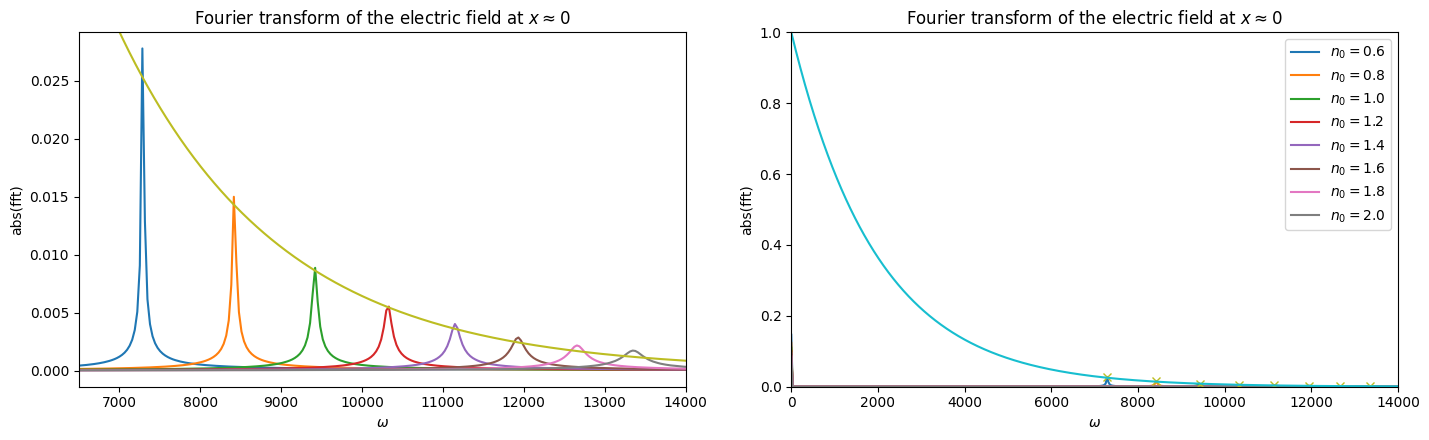

In [40]:
["ne", "Te", "ue", "charge", "potential", "electric"]
["-", "-.", "-", "--", "--", "--"]

#fig, axs = plt.subplots(1, 2, figsize=(8*0.9, 3.5*0.9))
fig, axs = plt.subplots(1, 2, figsize=(8*0.9*2, 5*0.9))

x       = sols[0].data_full["x"]
x_len   = x[-1] - x[0]
t       = sols[0].data_full["t"]
data    = [sol.data_full["electric"] for sol in sols]
n_0     = [sol.params["init"]["n_0"] for sol in sols]
peak_pos = 9420
probe_index = int(len(x)/2) + 0
print(x[probe_index-1])
print(probe_index)

ymax = 0
fft_max = []
fft_freq_max = []
for ax in axs:
    fft_max = []
    fft_freq_max = []
    for i, y in enumerate(data):
        y_probe = y[:, probe_index]

        fft = abs(np.fft.rfft(y_probe))
        freq_omega = 2*np.pi * np.fft.rfftfreq(y_probe.shape[-1], d=t[1]-t[0])

        fft_max.append(max(fft[10:]))
        fft_freq_max.append(freq_omega[fft == fft_max[-1]][0])

        label = "$n_0 = {:.1f}$".format(n_0[i])
        ax.plot(freq_omega, fft, '-', label=label)

        if max(fft[10:]) > ymax:
            ymax = max(fft[10:])

    
    ylim = (-ymax * 0.05, ymax * 1.05)

    ax.set_title(r"Fourier transform of the electric field at $x \approx 0$")
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel("abs(fft)")
    ax.set_xlim((6500, 14000))
    ax.set_ylim(ylim)

    plt.legend()

for X, Y in zip(fft_freq_max,fft_max):
    print(f"x_peaks = {X:.5f}\t\ty_peaks = {Y*1e3:.10f}")

plt.plot(fft_freq_max, fft_max, 'x')
fig.tight_layout()
#plt.savefig("Wiggle_fourier_vary_n0", dpi=400)

ax.set_xlim((0, 14000))
ax.set_ylim((0,1))

mu = sols[0].params["physical"]["mu"]
eta = sols[0].params["physical"]["resistivity"]
n_e0 = 0.6

print((eta/2/mu*n_e0))

def f(omega):
    return np.exp(-omega/(eta/2/mu*n_e0)/18000)

integral = np.trapz(fft_max, fft_freq_max)
print("integral", integral)

X = np.linspace(1, 14000, 2000)
axs[0].plot(X, f(X))
axs[1].plot(X, f(X))
plt.show()

In [25]:
for sol, omega_sim in zip(sols, fft_freq_max):
    mu = sol.params["physical"]["mu"]
    eD = sol.params["physical"]["epsilon_D"]
    n0  = sol.params["init"]["n_0"]
    omega_theo = np.sqrt(n0/(mu*eD))
    
    print(n0, omega_sim)
    

0.6 7286.066267572462
0.8 8416.662757368189
1.0 9421.63741496439
1.2 10332.395698410948
1.4 11148.937607707863
1.6 11934.074058954895
1.8 12656.399594102166
2.0 13347.319671199555


In [2]:
solsH = [
    load_data(filename="DATA/Plasma-freq_data varying n0/n=0.60 LARGE"),
    load_data(filename="DATA/Plasma-freq_data varying n0/n=2.00 LARGE")
]

Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero


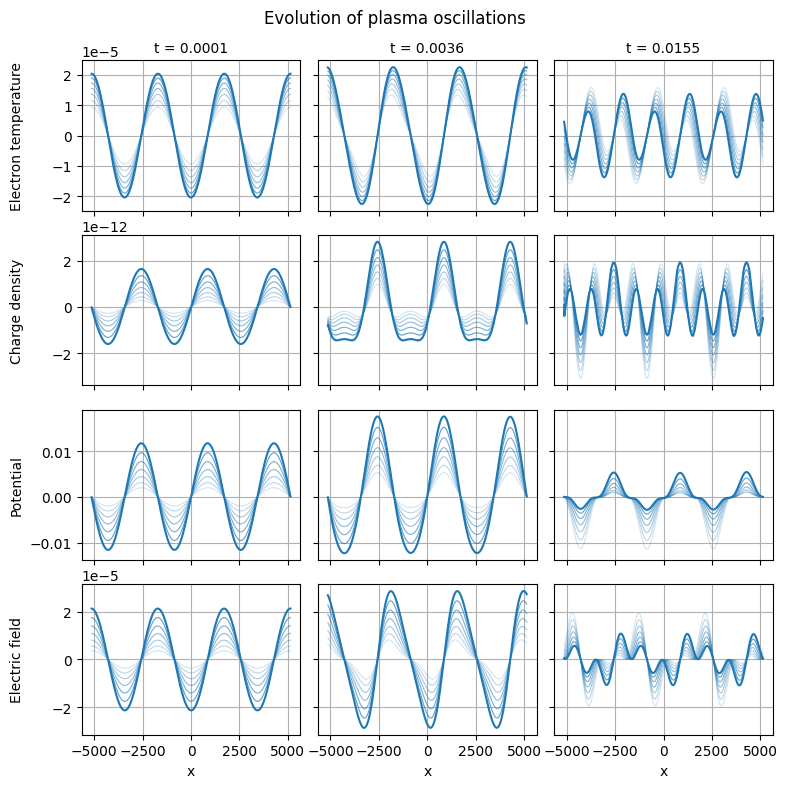

In [12]:
from methods.SolutionClass2 import _find_limits

fig, axs = plt.subplots(4, 3, figsize=(8,8), sharex=True, sharey='row')

sol = solsH[0]
for i, ti in enumerate([20, 540, 2330]):
    t       = sol.data_full["t"]
    x       = sol.data_full["x"]
    e_temp  = sol.data_full["ue"]
    charge  = sol.data_full["charge"]
    pot     = sol.data_full["potential"]
    E_field = sol.data_full["electric"]
    
    # Plots trails
    iter1 = zip([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1])
    iter2 = zip([2, 4, 6, 8, 10, 12], [0.7, 0.6, 0.5, 0.4, 0.3, 0.2])
    for j, alpha in iter2:
        axs[0][i].plot(x, e_temp[ti-j],  color=colorlist[0], alpha=alpha, linewidth=0.8)
        axs[1][i].plot(x, charge[ti-j],  color=colorlist[0], alpha=alpha, linewidth=0.8)
        axs[2][i].plot(x, pot[ti-j],     color=colorlist[0], alpha=alpha, linewidth=0.8)
        axs[3][i].plot(x, E_field[ti-j], color=colorlist[0], alpha=alpha, linewidth=0.8)

    axs[0][i].plot(x, e_temp[ti],  color=colorlist[0], alpha=1.0)
    axs[1][i].plot(x, charge[ti],  color=colorlist[0], alpha=1.0)
    axs[2][i].plot(x, pot[ti],     color=colorlist[0], alpha=1.0)
    axs[3][i].plot(x, E_field[ti], color=colorlist[0], alpha=1.0)

    axs[0][i].set_title(f"t = {t[ti]:.4f}", fontsize=10)

    for ax in axs:
        ax[i].grid()

axs[0][0].set_ylabel(r"Electron temperature")
axs[1][0].set_ylabel(r"Charge density")
axs[2][0].set_ylabel(r"Potential")
axs[3][0].set_ylabel(r"Electric field")
for ax in axs[-1]:
    ax.set_xlabel(r"x")

fig.suptitle("Evolution of plasma oscillations")
fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(wspace = 0.08, hspace = 0.16)
plt.savefig("Figures/temp_wiggles", dpi=400)

In [6]:
import copy
params1 = copy.deepcopy(sols[0].params)
params1["grid"]["Nx"] = 1000
params1["output"]["tend"] = 0.04
params1["output"]["maxout"] = 6000
params2 = copy.deepcopy(sols[-1].params)
params2["grid"]["Nx"] = 1000
params2["output"]["tend"] = 0.04
params2["output"]["maxout"] = 6000

solH1 = SolutionClass(params1)
print("done1")
solH2 = SolutionClass(params2)
print("done2")

done1
done2


In [7]:
save_data(solH1, filename="DATA/Plasma-freq_data varying n0/n=0.60 LARGE")
save_data(solH2, filename="DATA/Plasma-freq_data varying n0/n=1.80 LARGE")

In [8]:
solH1 = load_data(filename="DATA/Plasma-freq_data varying n0/n=0.60 LARGE")
solH2 = load_data(filename="DATA/Plasma-freq_data varying n0/n=1.80 LARGE")

Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero


In [9]:
solH1.constants
eta = 0.0001
mu  = 0.00027244371074816386

{'grid': {'Nx': 32, 'x': [-5136.503988619312, 5136.503988619312]},
 'init': {'type': 'soft-step',
  'x_a': 0.0,
  'alpha': 0.1,
  'n_l': 1,
  'n_r': 0.2,
  't_l': 1,
  't_r': 0.2},
 'advection': {'type': 'staggered', 'variant': 'original'},
 'timestepper': {'type': 'ARK',
  'tableau': 'ARK-4-2-3',
  'rtol': 1e-06,
  'atol': 1e-07},
 'physical': {'type': 'original',
  'nu_u': [3699.9999997807186, 114.28646516475492],
  'nu_n': [0.0, 0.0],
  'nu_t': [0.0, 0.0],
  'resistivity': 0.0001,
  'mu': 0.00027244371074816386,
  'epsilon_D': 4.145891933094266e-05},
 'bc': {'density': 'NEU',
  'velocity': 'NEU',
  'pressure': 'NEU',
  'potential': 'DIR_NEU'},
 'poisson': {'type': 'gmres',
  'max_inner': 30,
  'max_outer': 3,
  'l_input': 3,
  'mMax': 10,
  'damping': 0.01,
  'eps': 1e-06},
 'output': {'tend': 0.001, 'maxout': 20}}

Done1


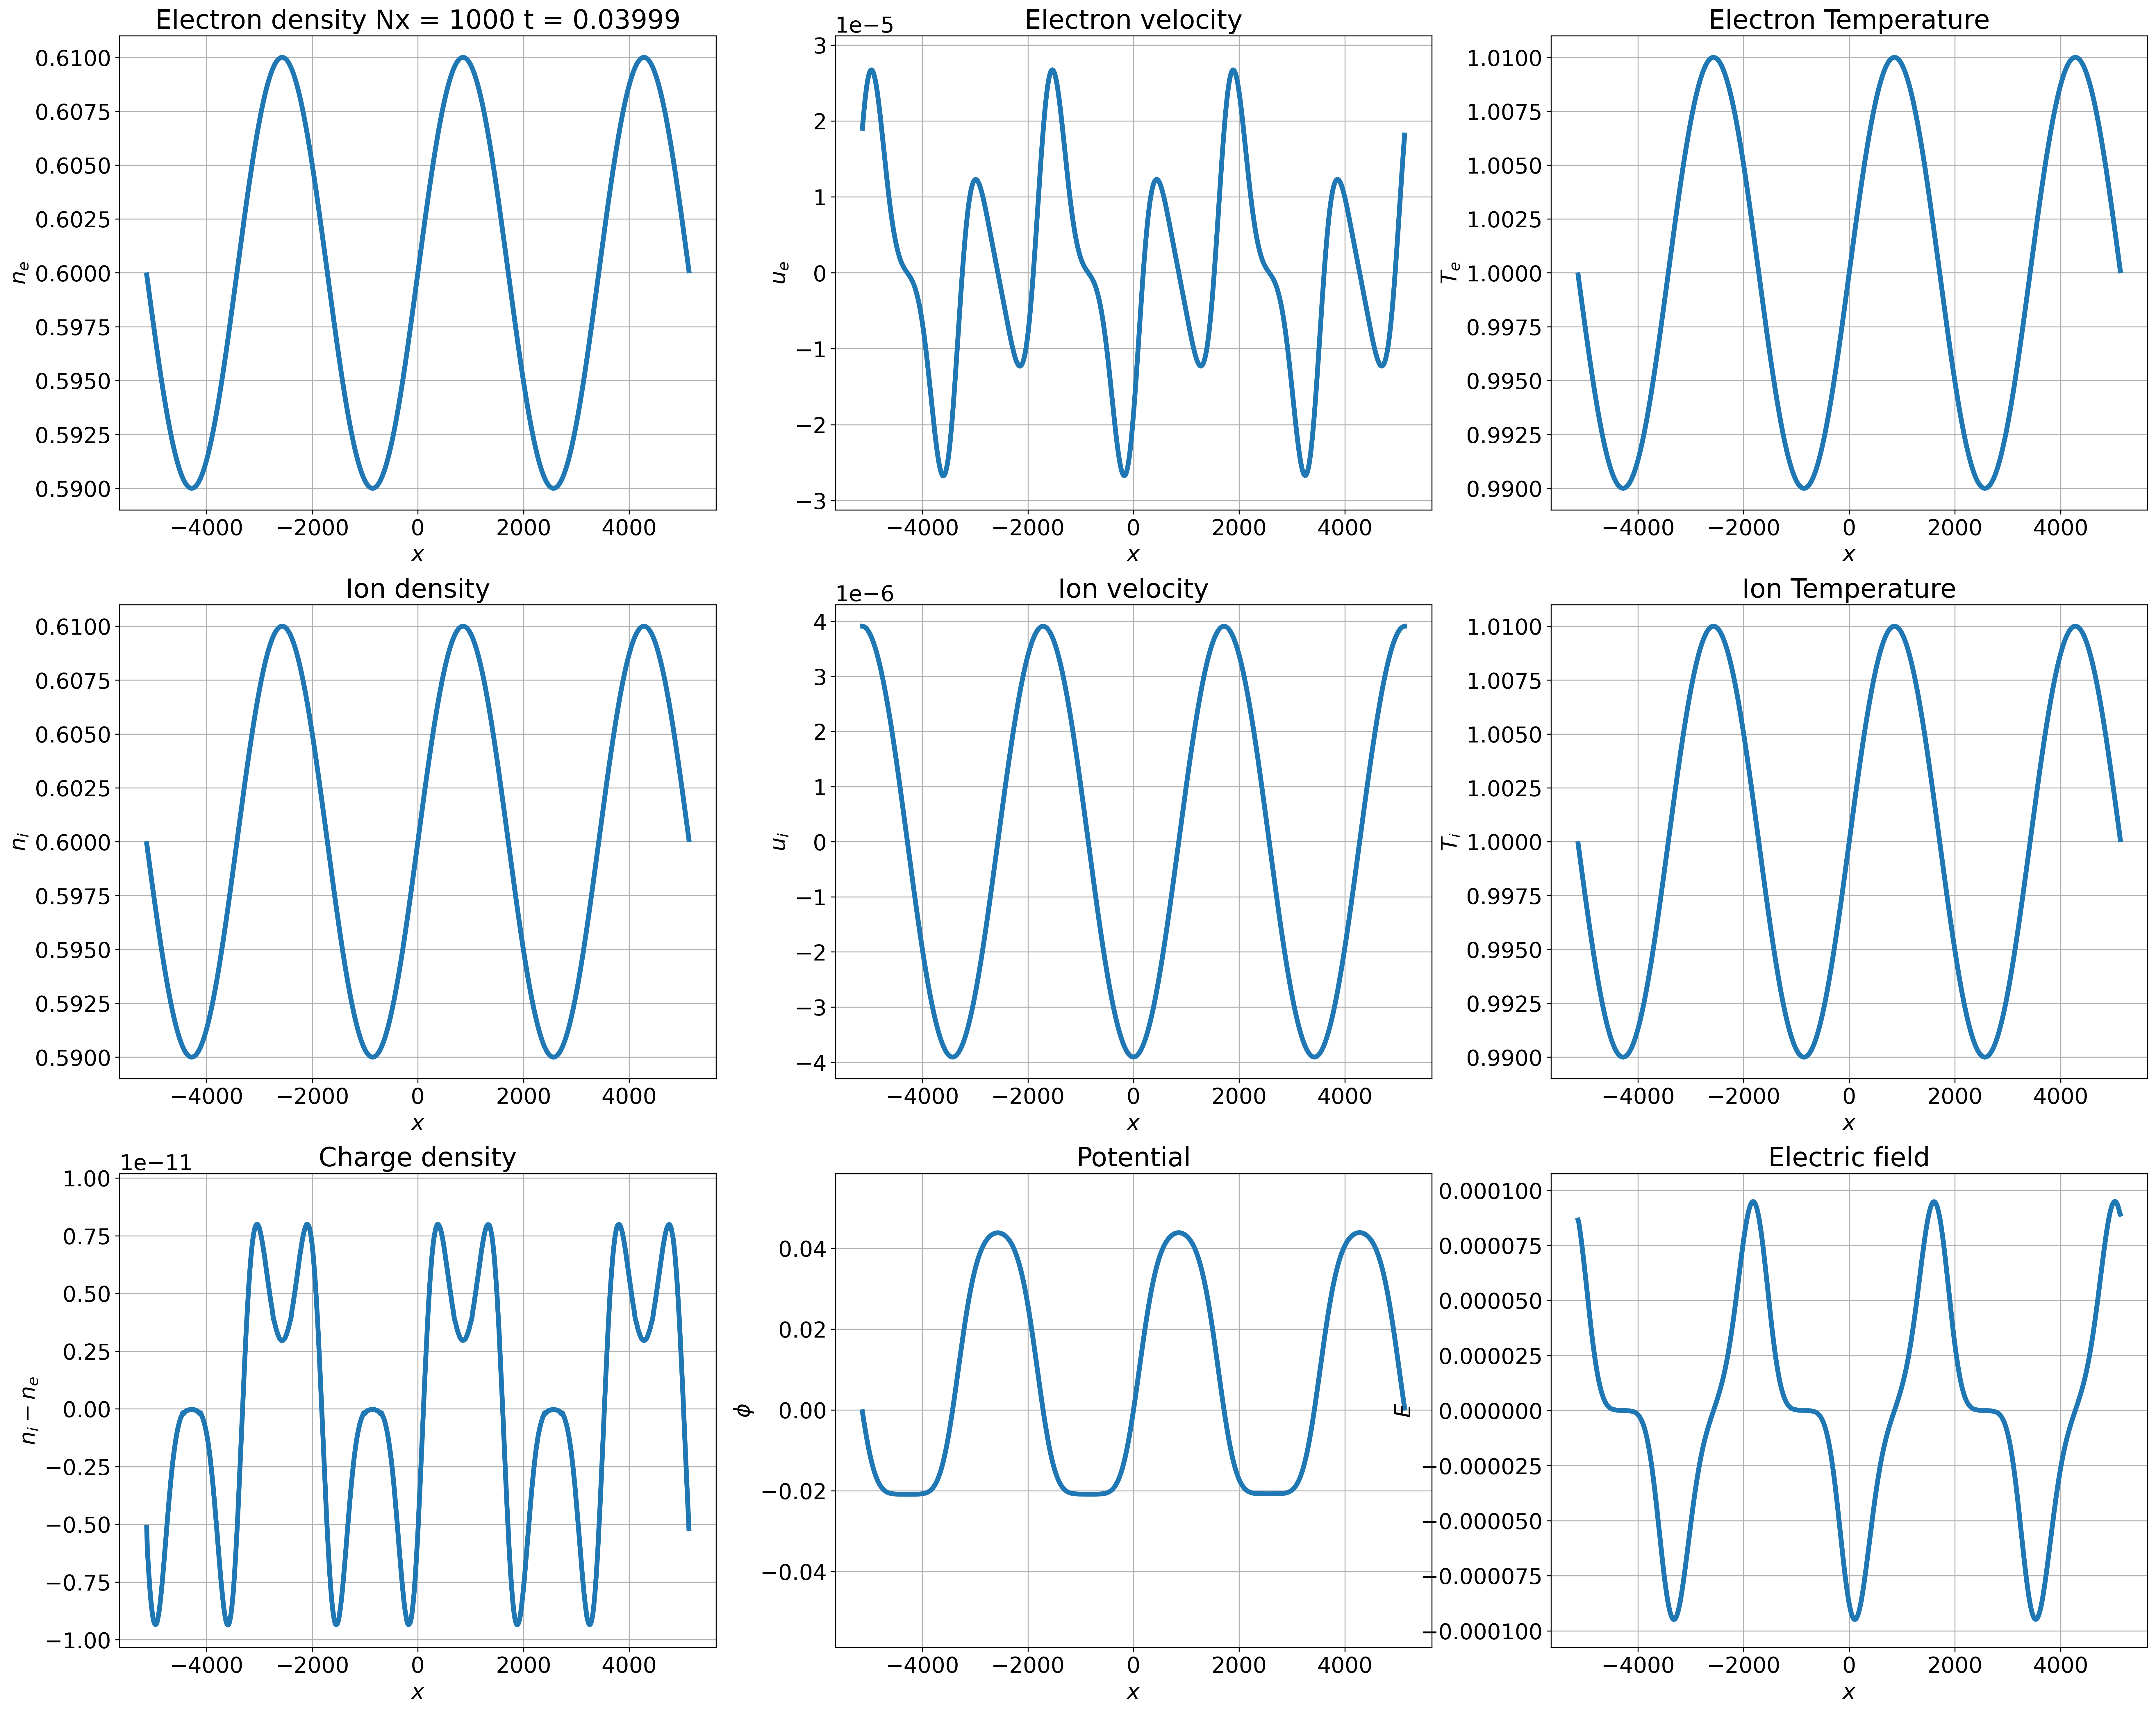

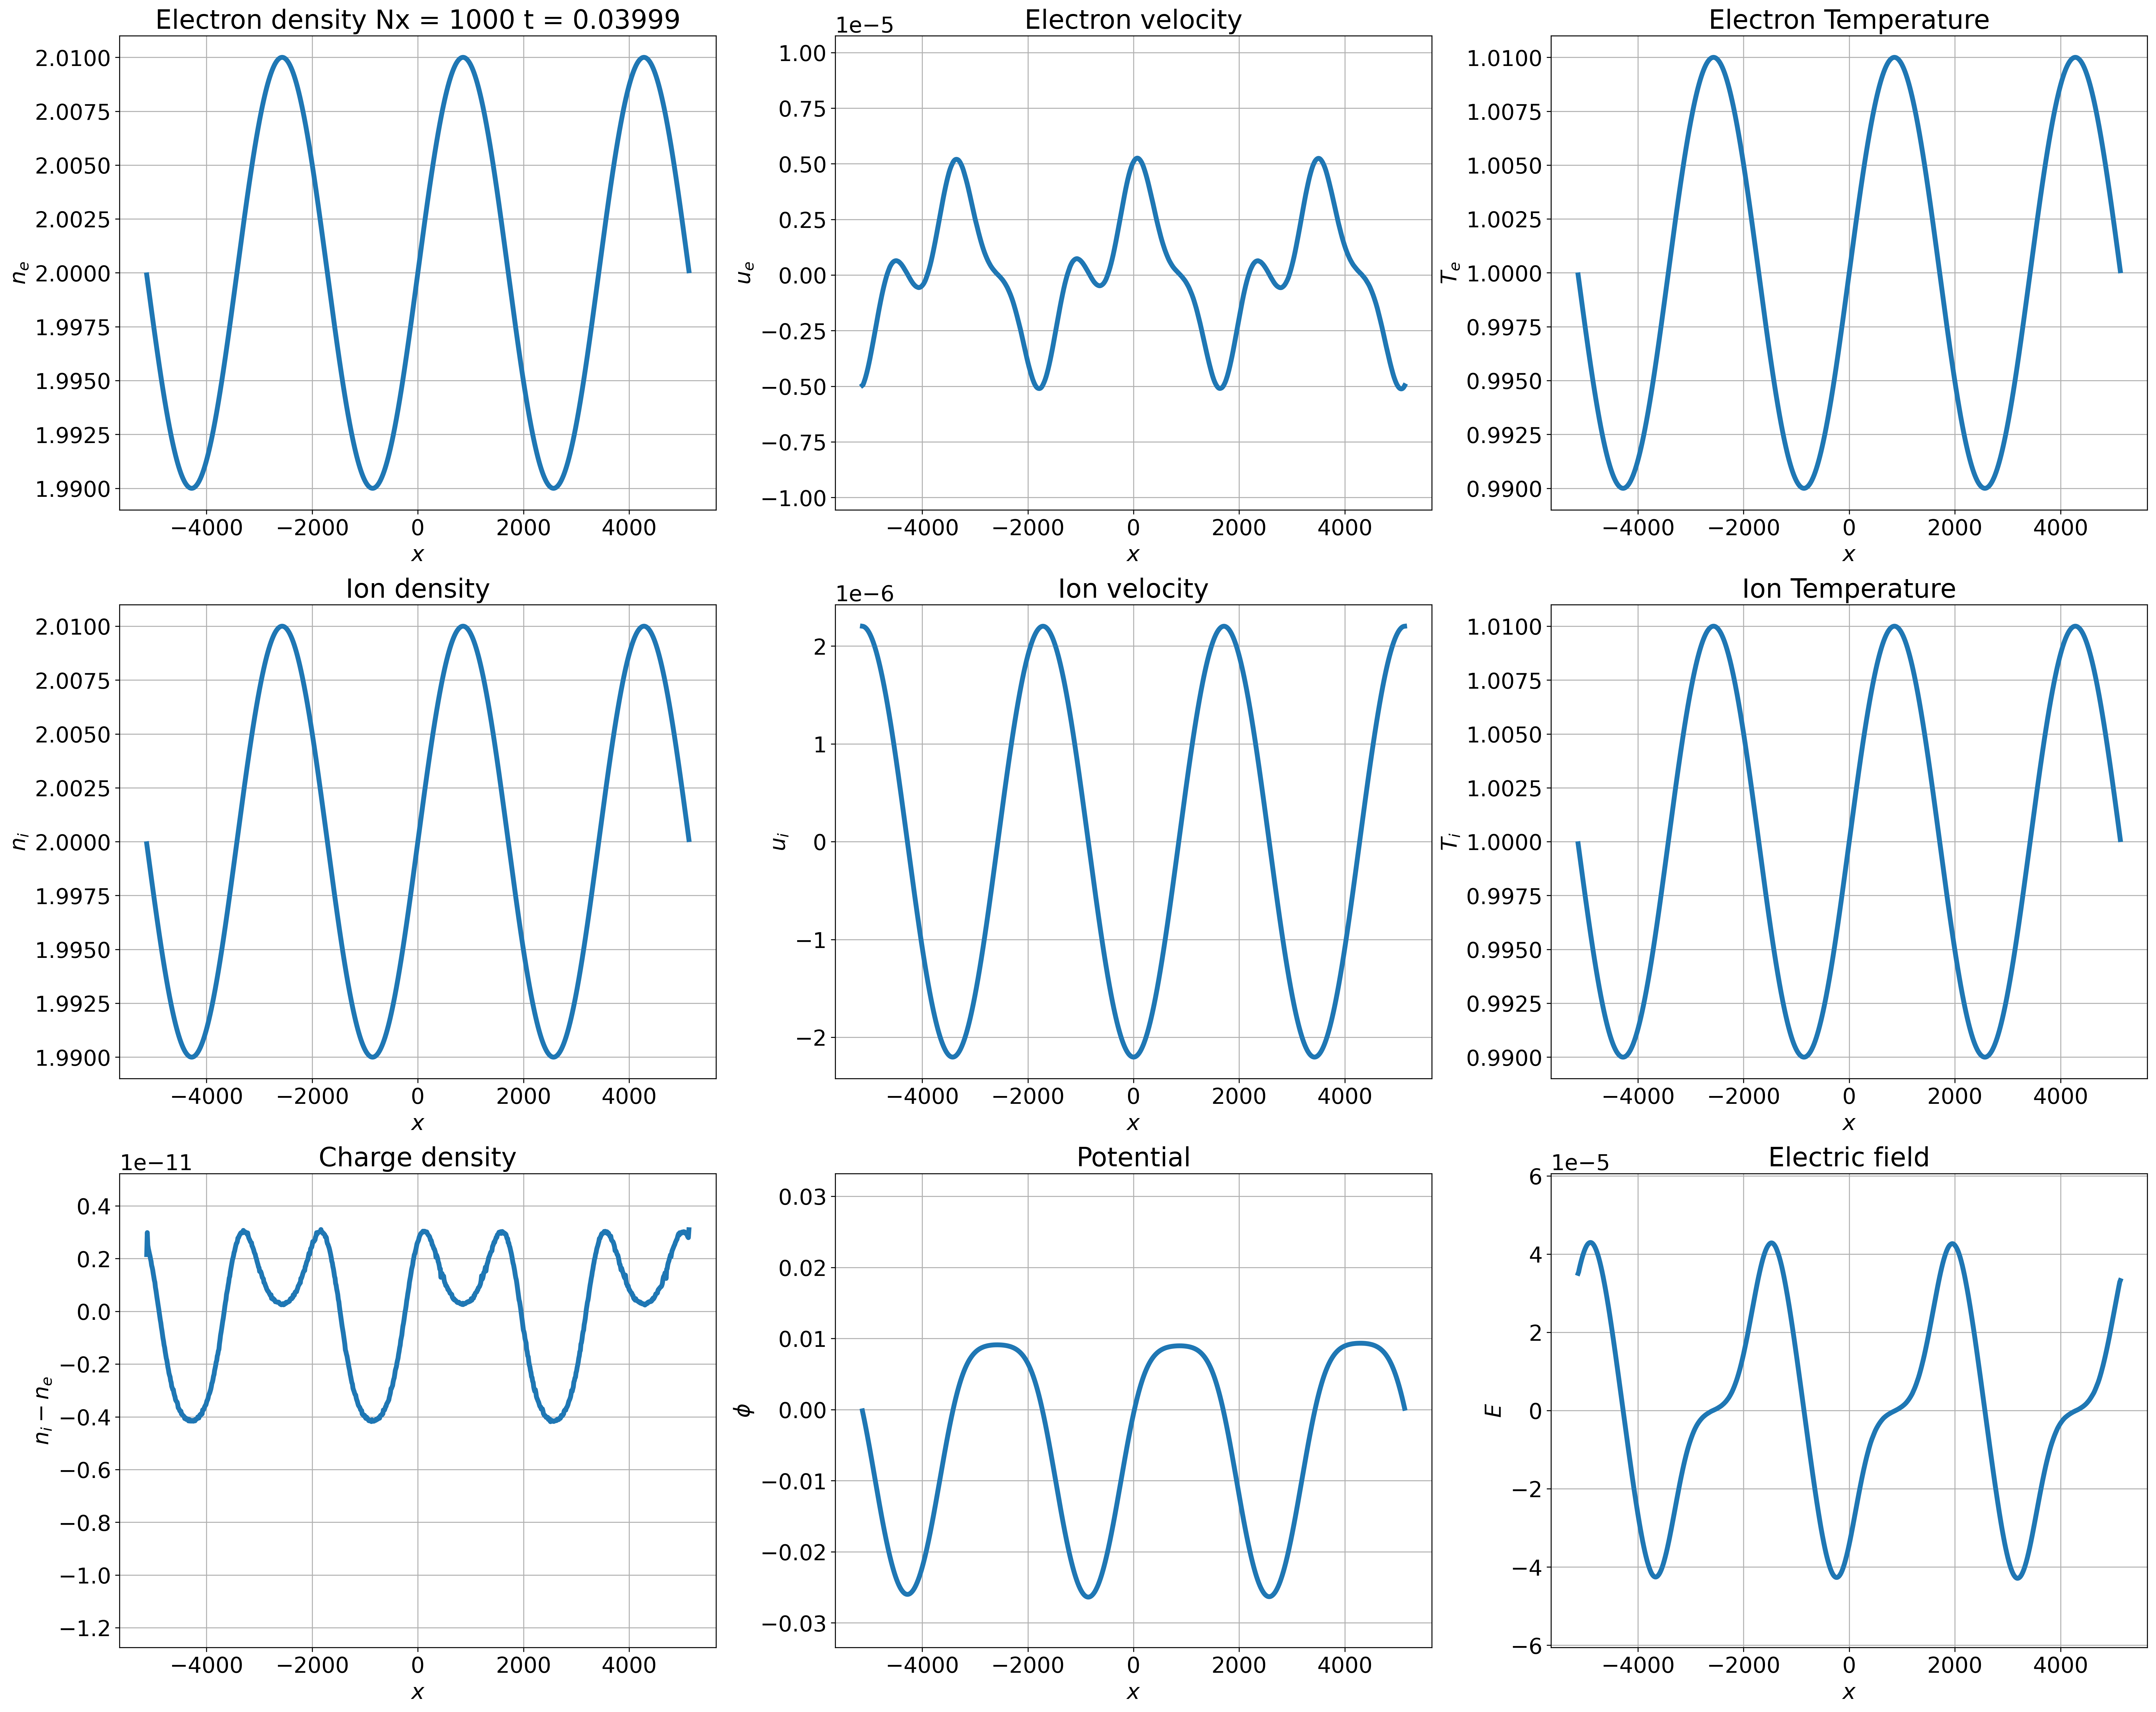

In [11]:
solH1.animate_all(filename="DATA/Plasma-freq_data varying n0/n=0.60 LARGE.mp4")
print("Done1")
solH2.animate_all(filename="DATA/Plasma-freq_data varying n0/n=2.00 LARGE.mp4")